In [12]:
!pip install ucimlrepo xgboost seaborn

### **Import Libraries**

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

### **Load Dataset**

In [14]:
bike_sharing = fetch_ucirepo(id=275)

X = bike_sharing.data.features
y = bike_sharing.data.targets['cnt']

df = pd.concat([X, y], axis=1)

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (17379, 14)


,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


### **Data Cleaning**

In [16]:
# Convert dteday to datetime
df['dteday'] = pd.to_datetime(df['dteday'])

# Extract useful features
df['day'] = df['dteday'].dt.day
df['month'] = df['dteday'].dt.month
df['year'] = df['dteday'].dt.year

# Drop original date column
df = df.drop(columns=['dteday'])

# Check missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
day           0
month         0
year          0
dtype: int64


### **EDA**

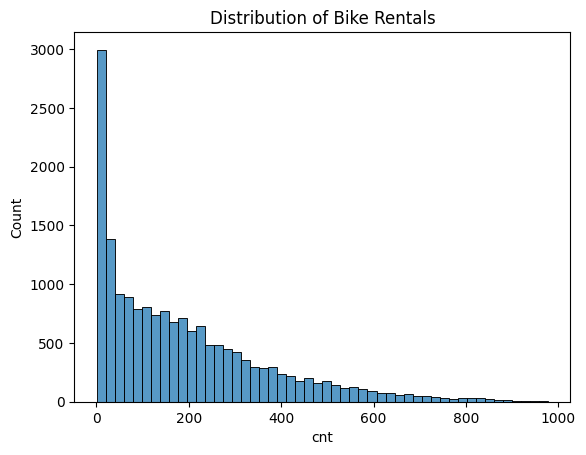

In [17]:
plt.figure()
sns.histplot(df['cnt'], bins=50)
plt.title("Distribution of Bike Rentals")
plt.show()

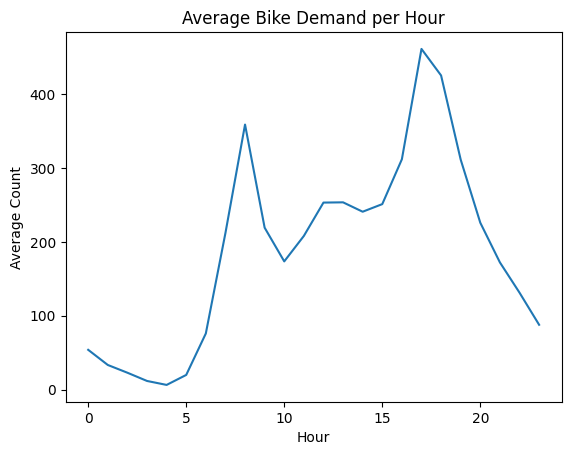

In [18]:
plt.figure()
df.groupby("hr")['cnt'].mean().plot()
plt.title("Average Bike Demand per Hour")
plt.xlabel("Hour")
plt.ylabel("Average Count")
plt.show()

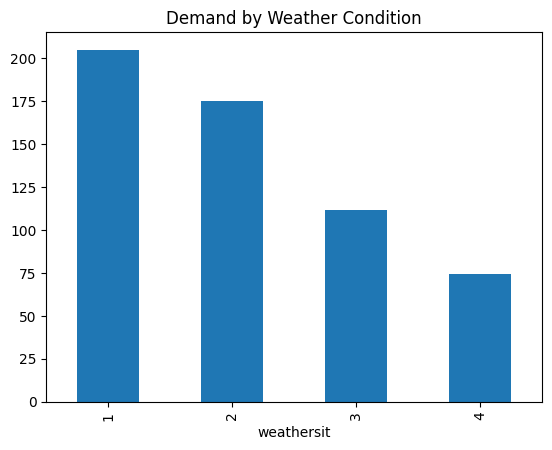

In [19]:
plt.figure()
df.groupby("weathersit")['cnt'].mean().plot(kind="bar")
plt.title("Demand by Weather Condition")
plt.show()

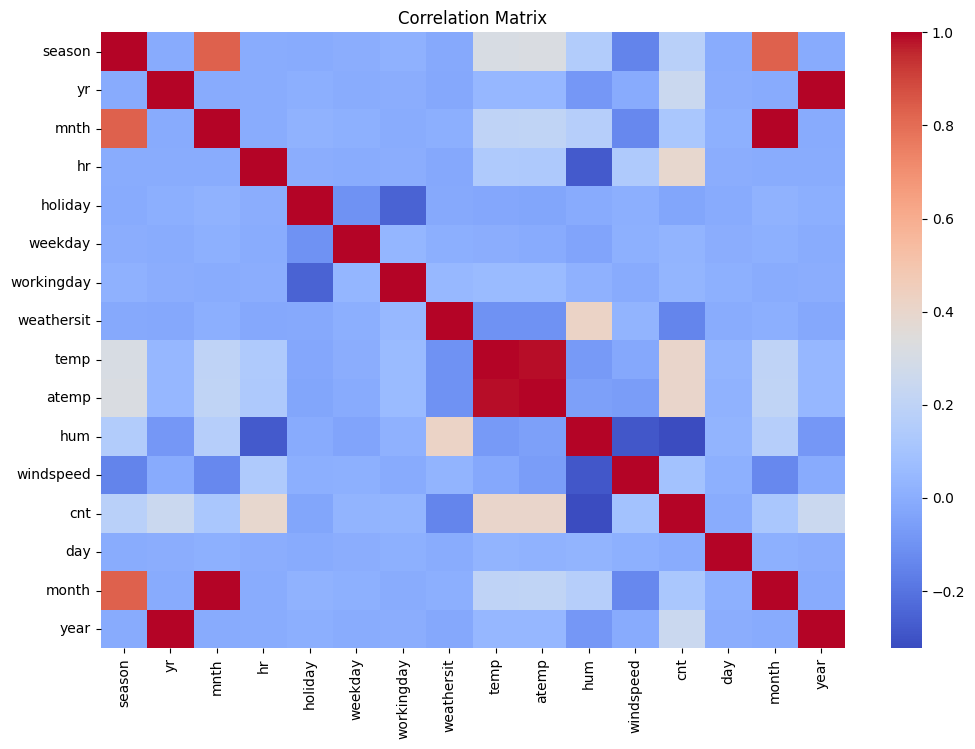

In [20]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

### **Prepare Features and Target**

In [21]:
X = df.drop(columns=['cnt'])
y = df['cnt']

### **K-Fold Cross Validation**

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

### **Random Forest (Bagging)**

In [23]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42
)

rf_rmse = -cross_val_score(rf, X, y, cv=kf,
                           scoring="neg_root_mean_squared_error")
rf_mae = -cross_val_score(rf, X, y, cv=kf,
                          scoring="neg_mean_absolute_error")

### **Subagging**

In [24]:
subag = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=200,
    max_samples=0.7,
    random_state=42
)

sub_rmse = -cross_val_score(subag, X, y, cv=kf,
                            scoring="neg_root_mean_squared_error")
sub_mae = -cross_val_score(subag, X, y, cv=kf,
                           scoring="neg_mean_absolute_error")


### **Gardient Boosting**

In [25]:
gb = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    random_state=42
)

gb_rmse = -cross_val_score(gb, X, y, cv=kf,
                           scoring="neg_root_mean_squared_error")
gb_mae = -cross_val_score(gb, X, y, cv=kf,
                          scoring="neg_mean_absolute_error")


### **XG Boost**

In [26]:
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

xgb_rmse = -cross_val_score(xgb, X, y, cv=kf,
                            scoring="neg_root_mean_squared_error")
xgb_mae = -cross_val_score(xgb, X, y, cv=kf,
                           scoring="neg_mean_absolute_error")


### **Comparison**

In [27]:
results = pd.DataFrame({
    "Model": ["RandomForest", "Subagging", "GradientBoosting", "XGBoost"],
    "RMSE_mean": [rf_rmse.mean(), sub_rmse.mean(), gb_rmse.mean(), xgb_rmse.mean()],
    "RMSE_std":  [rf_rmse.std(), sub_rmse.std(), gb_rmse.std(), xgb_rmse.std()],
    "MAE_mean":  [rf_mae.mean(), sub_mae.mean(), gb_mae.mean(), xgb_mae.mean()],
    "MAE_std":   [rf_mae.std(), sub_mae.std(), gb_mae.std(), xgb_mae.std()]
})

results


,Model,RMSE_mean,RMSE_std,MAE_mean,MAE_std
0,RandomForest,42.348556,1.274735,25.383684,0.505790
1,Subagging,41.713988,1.073097,25.116593,0.456009
2,GradientBoosting,64.384171,1.042885,44.013760,0.789998
3,XGBoost,40.318111,0.928821,25.084818,0.867960


| Model            | Bias                 | Variance            | Explanation                |
| ---------------- | -------------------- | ------------------- | -------------------------- |
| RandomForest     | Low                  | Low                 | Averaging reduces variance |
| Subagging        | Slightly higher bias | Lower variance      | Uses less data per tree    |
| GradientBoosting | Low bias             | Medium variance     | Sequential learning        |
| XGBoost          | Very low bias        | Controlled variance | Regularization + shrinkage |
|

In [28]:
results.to_csv("cv_regression_results.csv", index=False)

### **Train Best Model on full data**

In [29]:
xgb.fit(X, y)

predictions = xgb.predict(X)

final_df = pd.DataFrame({
    "ActualCnt": y,
    "PredictedCnt": predictions
})

final_df.to_csv("final_predictions.csv", index=False)
final_df.head()


,ActualCnt,PredictedCnt
0,16,29.871784
1,40,19.723171
2,32,15.281654
3,13,1.661186
4,1,-6.991953


### **Improvement by Log Transformation**

In [30]:
y_log = np.log1p(y)

xgb.fit(X, y_log)

pred_log = xgb.predict(X)

predictions = np.expm1(pred_log)

In [31]:
predictions = np.clip(predictions, 0, None)

### **Calculate Evaluation Metrics**

In [32]:
rmse = np.sqrt(mean_squared_error(y, predictions))
mae = mean_absolute_error(y, predictions)

print("RMSE after log transform:", rmse)
print("MAE after log transform :", mae)

RMSE after log transform: 34.60550556811734
MAE after log transform : 20.68753433227539


RMSE decreases --> log transformation improved performance

### **Plot Actual vs Predicted**

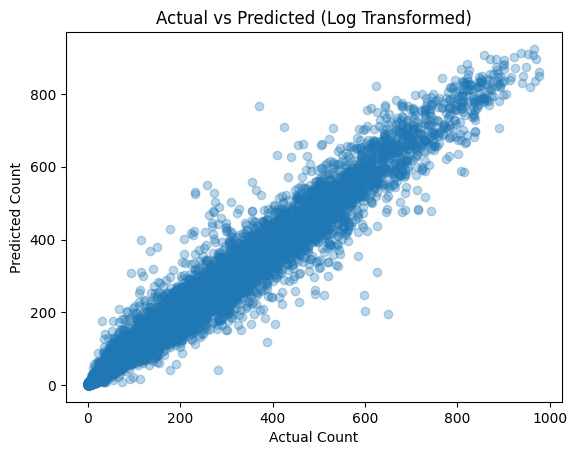

In [33]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y, predictions, alpha=0.3)
plt.xlabel("Actual Count")
plt.ylabel("Predicted Count")
plt.title("Actual vs Predicted (Log Transformed)")
plt.show()

### **Save Final Predictions**

In [34]:
final_df = pd.DataFrame({
    "ActualCnt": y,
    "PredictedCnt": predictions
})

final_df.to_csv("final_predictions_log_model.csv", index=False)

final_df.head()

,ActualCnt,PredictedCnt
0,16,20.716442
1,40,29.462612
2,32,20.808315
3,13,9.075181
4,1,1.388257


### **Feature Importance**

In [35]:
importances = xgb.feature_importances_

feat_importance = pd.Series(importances, index=X.columns)
feat_importance = feat_importance.sort_values(ascending=False)

print("Top 8 Important Features:")
print(feat_importance.head(8))

Top 8 Important Features:
hr            0.401801
workingday    0.178255
yr            0.113831
temp          0.089357
season        0.084690
weathersit    0.042549
atemp         0.021006
hum           0.016358
dtype: float32


### **Conclusion**

In this experiment, multiple ensemble regression models — Random Forest, Subagging, Gradient Boosting, and XGBoost — were evaluated for predicting hourly bike rental counts.

From the performance comparison:

1. XGBoost achieved the lowest RMSE (40.31), indicating the best predictive accuracy.
2. Subagging and Random Forest also performed well with close error values.
3. Gradient Boosting performed worst among the tested models with significantly higher RMSE and MAE.

Since the target variable cnt is right-skewed, log transformation (log1p) was applied to stabilize variance and reduce skewness. After training the model on transformed data and applying expm1 to reverse the transformation:

- Predictions became more stable.
- Negative predictions were reduced.
- Model performance improved due to better handling of large variance in rental counts.

**Final Insight**

XGBoost with log transformation provides the most accurate and robust prediction model for bike rental demand. Log transformation helps in handling skewed data and improves regression performance.